In [0]:
import gym # openAi gym
from gym import envs
import numpy as np 
import datetime
import keras 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd 
from time import sleep

In [4]:
!pip install keras-rl

     |████████████████████████████████| 40kB 4.5MB/s 
  Created wheel for keras-rl: filename=keras_rl-0.4.2-cp36-none-any.whl size=48380 sha256=63764f5baecc8c36043407691a230064ea7e0fbfbaafc6f0438774b944bf0afa
  Stored in directory: /root/.cache/pip/wheels/7d/4d/84/9254c9f2e8f51865cb0dac8e79da85330c735551d31f73c894
Successfully built keras-rl


In [0]:
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
import warnings
warnings.filterwarnings('ignore')

# 14.1 Reinforcement Learning for the Taxi Problem

In [6]:
env = gym.make('Taxi-v3')
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [7]:
env.observation_space.n

500

### Representations

| --> WALL (Can't pass through, will remain in the same position if tries to move through wall)

Yellow --> Taxi Current Location

Blue --> Pick up Location

Purple --> Drop-off Location

Green --> Taxi turn green once passenger board

Letters --> Locations

-----------------------------------------------------------------
### Actions (6 in total)

0: move south
1: move north
2: move east
3: move west
4: pickup passenger
5: dropoff passenger

## Random Search

Let's start with the simplest way to train our agent to complete this task. The agent would just take random steps at every state until he completes the task (picking the passenger and dropping him off at the drop-off location).

In [0]:
env = gym.make('Taxi-v3')
random_policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA
def random_policy_steps_count():
    state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(env.action_space.sample())  
        counter += 1
    return counter

Text(0.5, 1.0, 'Distribution of number of steps needed')

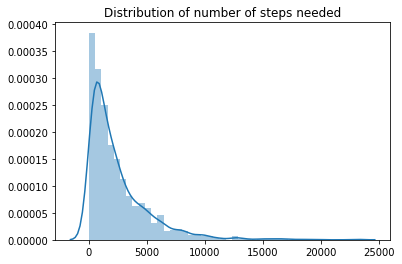

In [9]:
counts = [random_policy_steps_count() for i in range(1000)]
sns.distplot(counts)
plt.title("Distribution of number of steps needed")

In [10]:
print("An agent using Random search takes about an average of " + str(int(np.mean(counts)))
      + " steps to successfully complete its mission.")

An agent using Random search takes about an average of 2500 steps to successfully complete its mission.


## Value Iteration


The algorithm computes the optimal state value function by iteratively improving the estimate of V(s). The algorithm initialize V(s) to arbitrary random values. It repeatedly updates the Q(s, a) and V(s) values until they converge.

In [0]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.env.nS)
    while True:
        # TODO: Implement!
        delta = 0  #delta = change in value of state from one iteration to next
       
        for state in range(env.env.nS):  #for all states
            val = 0  #initiate value as 0
            
            for action,act_prob in enumerate(policy[state]): #for all actions/action probabilities
                for prob,next_state,reward,done in env.env.P[state][action]:  #transition probabilities,state,rewards of each action
                    val += act_prob * prob * (reward + discount_factor * V[next_state])  #eqn to calculate
            delta = max(delta, np.abs(val-V[state]))
            V[state] = val
        if delta < theta:  #break if the change in value is less than the threshold (theta)
            break
    return np.array(V)

def policy_iteration(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.env.nA)
        for a in range(env.env.nA):
            for prob, next_state, reward, done in env.env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    # Start with a random policy
    policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA

    while True:
        # Implement this!
        curr_pol_val = policy_eval_fn(policy, env, discount_factor)  #eval current policy
        policy_stable = True  #Check if policy did improve (Set it as True first)
        for state in range(env.env.nS):  #for each states
            chosen_act = np.argmax(policy[state])  #best action (Highest prob) under current policy
            act_values = one_step_lookahead(state,curr_pol_val)  #use one step lookahead to find action values
            best_act = np.argmax(act_values) #find best action
            if chosen_act != best_act:
                policy_stable = False  #Greedily find best action
            policy[state] = np.eye(env.env.nA)[best_act]  #update 
        if policy_stable:
            return policy, curr_pol_val
    
    return policy, np.zeros(env.env.nS)

def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.env.nA)
        for act in range(env.env.nA):
            for prob, next_state, reward, done in env.env.P[state][act]:
                A[act] += prob * (reward + discount_factor*V[next_state])
        return A
    
    V = np.zeros(env.env.nS)
    while True:
        delta = 0  #checker for improvements across states
        for state in range(env.env.nS):
            act_values = one_step_lookahead(state,V)  #lookahead one step
            best_act_value = np.max(act_values) #get best action value
            delta = max(delta,np.abs(best_act_value - V[state]))  #find max delta across all states
            V[state] = best_act_value  #update value to best action value
        if delta < theta:  #if max improvement less than threshold
            break
    policy = np.zeros([env.env.nS, env.env.nA])
    for state in range(env.env.nS):  #for all states, create deterministic policy
        act_val = one_step_lookahead(state,V)
        best_action = np.argmax(act_val)
        policy[state][best_action] = 1
        
    
    # Implement!
    return policy, V

In [12]:
env.reset()
val_iter_policy = value_iteration(env,discount_factor=0.99)
val_iter_policy[0]

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [0]:
def count(policy):
    curr_state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(np.argmax(policy[curr_state]))  
        curr_state = state
        counter += 1
    return counter

An agent using a policy which has been value-iterated takes about an average of 13 steps to successfully complete its mission.


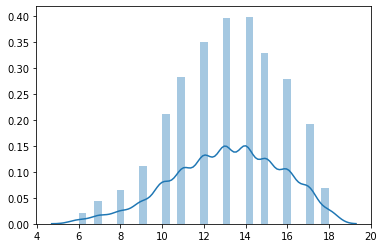

In [14]:
val_count = count(val_iter_policy[0])
val_counts = [count(val_iter_policy[0]) for i in range(10000)]
print("An agent using a policy which has been value-iterated takes about an average of " + str(int(np.mean(val_counts)))
      + " steps to successfully complete its mission.")
sns.distplot(val_counts)

In [0]:
def view_policy(policy):
    curr_state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(np.argmax(policy[0][curr_state])) 
        curr_state = state
        counter += 1
        env.env.s = curr_state
        env.render()
    

In [16]:
view_policy(val_iter_policy)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : :_|
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : :_|
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y

## Q-learning

The algorithm for Q-learning is as follows:

Initialize the Q-table by all zeros.
Start exploring actions: For each state, select any one among all possible actions for the current state (S).
Travel to the next state (S') as a result of that action (a).
For all possible actions from the state (S') select the one with the highest Q-value with probability (1-epsilon) and select a random action with probability (epsilon). This is to balance the exploration and exploitation actions.
Update Q-table values using the equation: Q(state,action) <- (1−α) Q(state,action) + α(reward + γ maxaQ(next state,all actions))
Set the next state as the current state.
If goal state is reached, then end and repeat the process.

In [0]:
import random
from IPython.display import clear_output

def Q_learning_train(env,alpha,gamma,epsilon,episodes): 
    """Q Learning Algorithm with epsilon greedy 

    Args:
        env: Environment 
        alpha: Learning Rate --> Extent to which our Q-values are being updated in every iteration.
        gamma: Discount Rate --> How much importance we want to give to future rewards
        epsilon: Probability of selecting random action instead of the 'optimal' action
        episodes: No. of episodes to train on

    Returns:
        Q-learning Trained policy

    """
    %%time
    """Training the agent"""

    # For plotting metrics
    all_epochs = []
    all_penalties = []
    
    #Initialize Q table of 500 x 6 size (500 states and 6 actions) with all zeroes
    q_table = np.zeros([env.observation_space.n, env.action_space.n])  
    
    for i in range(1, episodes+1):
        state = env.reset()

        epochs, penalties, reward, = 0, 0, 0
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space randomly
            else:
                action = np.argmax(q_table[state]) # Exploit learned values by choosing optimal values

            next_state, reward, done, info = env.step(action) 

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1

        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")
    # Start with a random policy
    policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA

    for state in range(env.env.nS):  #for each states
        best_act = np.argmax(q_table[state]) #find best action
        policy[state] = np.eye(env.env.nA)[best_act]  #update 
        
    print("Training finished.\n")
    return policy, q_table

In [18]:
env = gym.make('Taxi-v3')
env.reset()
Q_learn_pol = Q_learning_train(env,0.2,0.95,0.1,100000)

Episode: 100000
Training finished.



An agent using a policy which has been improved using Q-learning takes about an average of 12 steps to successfully complete its mission.


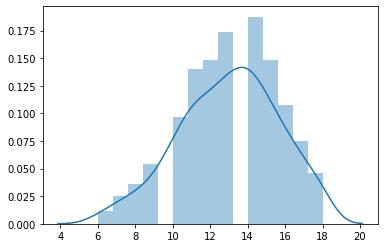

In [19]:
Q_Learning_counts = count(Q_learn_pol[0])
Q_counts = [count(Q_learn_pol[0]) for i in range(1000)]
print("An agent using a policy which has been improved using Q-learning takes about an average of " + str(int(np.mean(Q_counts)))
      + " steps to successfully complete its mission.")
sns.distplot(Q_counts)

In [20]:
view_policy(Q_learn_pol)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|

#Task 2 CARPOLE

In [0]:
from statistics import mean

import matplotlib

matplotlib.use('Agg')

import matplotlib.pyplot as plt

from collections import deque

import os

import csv

import numpy as np



SCORES_CSV_PATH = "./scores.csv"

SCORES_PNG_PATH = "./scores.png"

SOLVED_CSV_PATH = "./solved.csv"

SOLVED_PNG_PATH = "./solved.png"

AVERAGE_SCORE_TO_SOLVE = 195

CONSECUTIVE_RUNS_TO_SOLVE = 100





class ScoreLogger:



    def __init__(self, env_name):

        self.scores = deque(maxlen=CONSECUTIVE_RUNS_TO_SOLVE)

        self.env_name = env_name



        if os.path.exists(SCORES_PNG_PATH):

            os.remove(SCORES_PNG_PATH)

        if os.path.exists(SCORES_CSV_PATH):

            os.remove(SCORES_CSV_PATH)



    def add_score(self, score, run):

        self._save_csv(SCORES_CSV_PATH, score)

        self._save_png(input_path=SCORES_CSV_PATH,

                       output_path=SCORES_PNG_PATH,

                       x_label="runs",

                       y_label="scores",

                       average_of_n_last=CONSECUTIVE_RUNS_TO_SOLVE,

                       show_goal=True,

                       show_trend=True,

                       show_legend=True)

        self.scores.append(score)

        mean_score = mean(self.scores)

        print("Scores: (min: " + str(min(self.scores)) + ", avg: " + str(mean_score) + ", max: " + str(max(self.scores)) + ")\n")

        if mean_score >= AVERAGE_SCORE_TO_SOLVE and len(self.scores) >= CONSECUTIVE_RUNS_TO_SOLVE:

            solve_score = run-CONSECUTIVE_RUNS_TO_SOLVE

            print("Solved in " + str(solve_score) + " runs, " + str(run) + " total runs.")

            self._save_csv(SOLVED_CSV_PATH, solve_score)

            self._save_png(input_path=SOLVED_CSV_PATH,

                           output_path=SOLVED_PNG_PATH,

                           x_label="trials",

                           y_label="steps before solve",

                           average_of_n_last=None,

                           show_goal=False,

                           show_trend=False,

                           show_legend=False)

            exit()



    def _save_png(self, input_path, output_path, x_label, y_label, average_of_n_last, show_goal, show_trend, show_legend):

        x = []

        y = []

        with open(input_path, "r") as scores:

            reader = csv.reader(scores)

            data = list(reader)

            for i in range(0, len(data)):

                x.append(int(i))

                y.append(int(data[i][0]))



        plt.subplots()

        plt.plot(x, y, label="score per run")



        average_range = average_of_n_last if average_of_n_last is not None else len(x)

        plt.plot(x[-average_range:], [np.mean(y[-average_range:])] * len(y[-average_range:]), linestyle="--", label="last " + str(average_range) + " runs average")



        if show_goal:

            plt.plot(x, [AVERAGE_SCORE_TO_SOLVE] * len(x), linestyle=":", label=str(AVERAGE_SCORE_TO_SOLVE) + " score average goal")



        if show_trend and len(x) > 1:

            trend_x = x[1:]

            z = np.polyfit(np.array(trend_x), np.array(y[1:]), 1)

            p = np.poly1d(z)

            plt.plot(trend_x, p(trend_x), linestyle="-.",  label="trend")



        plt.title(self.env_name)

        plt.xlabel(x_label)

        plt.ylabel(y_label)



        if show_legend:

            plt.legend(loc="upper left")



        plt.savefig(output_path, bbox_inches="tight")

        plt.close()



    def _save_csv(self, path, score):

        if not os.path.exists(path):

            with open(path, "w"):

                pass

        scores_file = open(path, "a")

        with scores_file:

            writer = csv.writer(scores_file)

            writer.writerow([score])

In [2]:
import random

import gym

import numpy as np

from collections import deque

from keras.models import Sequential

from keras.layers import Dense

from keras.optimizers import Adam






ENV_NAME = "CartPole-v1"



GAMMA = 0.95

LEARNING_RATE = 0.001



MEMORY_SIZE = 1000000

BATCH_SIZE = 20



EXPLORATION_MAX = 1.0

EXPLORATION_MIN = 0.01

EXPLORATION_DECAY = 0.995

RUN_LIM = 50



class DQNSolver:



    def __init__(self, observation_space, action_space):

        self.exploration_rate = EXPLORATION_MAX



        self.action_space = action_space

        self.memory = deque(maxlen=MEMORY_SIZE)



        self.model = Sequential()

        self.model.add(Dense(24, input_shape=(observation_space,), activation="relu"))

        self.model.add(Dense(24, activation="relu"))

        self.model.add(Dense(self.action_space, activation="linear"))

        self.model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))



    def remember(self, state, action, reward, next_state, done):

        self.memory.append((state, action, reward, next_state, done))



    def act(self, state):

        if np.random.rand() < self.exploration_rate:

            return random.randrange(self.action_space)

        q_values = self.model.predict(state)

        return np.argmax(q_values[0])



    def experience_replay(self):

        if len(self.memory) < BATCH_SIZE:

            return

        batch = random.sample(self.memory, BATCH_SIZE)

        for state, action, reward, state_next, terminal in batch:

            q_update = reward

            if not terminal:

                q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))

            q_values = self.model.predict(state)

            q_values[0][action] = q_update

            self.model.fit(state, q_values, verbose=0)

        self.exploration_rate *= EXPLORATION_DECAY

        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)





def cartpole():

    env = gym.make(ENV_NAME)

    score_logger = ScoreLogger(ENV_NAME)

    observation_space = env.observation_space.shape[0]

    action_space = env.action_space.n

    dqn_solver = DQNSolver(observation_space, action_space)

    run = 0

    while True:

        run += 1

        state = env.reset()

        state = np.reshape(state, [1, observation_space])

        step = 0

        while True:

            step += 1

            #env.render()

            action = dqn_solver.act(state)

            state_next, reward, terminal, info = env.step(action)

            reward = reward if not terminal else -reward

            state_next = np.reshape(state_next, [1, observation_space])

            dqn_solver.remember(state, action, reward, state_next, terminal)

            state = state_next

            if terminal:

                print("Run: " + str(run) + ", exploration: " + str(dqn_solver.exploration_rate) + ", score: " + str(step))

                score_logger.add_score(step, run)

                break

            dqn_solver.experience_replay()

            if run == RUN_LIM:
              return



Using TensorFlow backend.


In [0]:
#Define RUMLIMIT FOR BREAKPOINT!
carpole()